# Detecting Emotions from Voice using a Neural Network and Transfer Learning
### Haoran Xu, John Siguenica, Jadyn George

Training dataset:
* RAVDESS, https://zenodo.org/record/1188976#.ZE14Ti_MLZ4

Relevant documentation:
* Fast.ai: https://fastai1.fast.ai/
* Librosa: https://librosa.org/doc/latest/index.html


## Preprocessing
First, we need to convert the .wav audio files into images that the neural network can work with.

In [ ]:
!pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 47.0 MB/s eta 0:00:00


In [ ]:
# Import relevant libraries

import re
import os
import librosa
import librosa.display

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

!pip install fastai
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.widgets import *


import wave
import speech_recognition as sr

In [ ]:
# Import the training dataset using mounted drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/')
path

Path('/content/drive/MyDrive/QAC_Dataset/sorted_data')

In [ ]:
path.ls()

(#10) [Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/neutral'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/disgust'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/calm'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/sad'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/.ipynb_checkpoints'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/models'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/angry'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/happy'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/fearful'),Path('/content/drive/MyDrive/QAC_Dataset/sorted_data/surprised')]

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import random

# Set the path to the main folder containing subfolders of emotions
sorted_data = '/content/drive/MyDrive/QAC_Dataset/sorted_data/'


# Set the path to the destination folders for training and testing data
train_folder = '/content/drive/MyDrive/QAC_Dataset/train_folder'
test_folder = '/content/drive/MyDrive/QAC_Dataset/test_folder'

# Get a list of subfolders in the main folder
subfolders = [f.name for f in os.scandir(sorted_data) if f.is_dir()]
subfolders.remove('.ipynb_checkpoints')
subfolders.remove('models')
print(subfolders)

# Create subfolders within the train and test folders for each emotion
for subfolder in subfolders:
    os.makedirs(os.path.join(train_folder, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_folder, subfolder), exist_ok=True)


# Create lists to hold file paths for training and testing data
train_files = []
test_files = []

# Iterate over the subfolders
for subfolder in subfolders:
    subfolder_path = os.path.join(sorted_data, subfolder)
    files = [f.name for f in os.scandir(subfolder_path) if f.is_file()]
    
    # Append file paths to the respective lists
    train_files.extend([os.path.join(subfolder_path, file) for file in files])
    test_files.extend([os.path.join(subfolder_path, file) for file in files])

    # Randomly select files for training and testing
    train_files, test_files = train_test_split(train_files + test_files, test_size=0.2, random_state=42)


# Move training files to the training folder
for file in train_files:
    print("CURRENT FILE:", file)
    subfolder = os.path.basename(os.path.dirname(file))
    print("TRAIN SUBFOLDER", subfolder)
    destination_folder = os.path.join(train_folder, subfolder)
    print("TRAIN DEST FOLDER", destination_folder)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(file, destination_folder)

# Move testing files to the testing folder
for file in test_files:
    print("CURRENT FILE:", file)
    subfolder = os.path.basename(os.path.dirname(file))
    print("TEST SUBFOLDER", subfolder)
    destination_folder = os.path.join(test_folder, subfolder)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(file, destination_folder)

In [ ]:
len(train_files)

2304

In [ ]:
len(test_files)

576

In [ ]:
test_files.sort()
test_files

In [ ]:
for file in train_files:
    if test_files in test_files:
      print('NOT GOOD')

In [ ]:
train_files

In [ ]:
test_files

In [ ]:
train_path = Path('/content/drive/MyDrive/QAC_Dataset/train_folder')
sorted_data = Path('/content/drive/MyDrive/QAC_Dataset/sorted_data')

train_path.ls()

(#10) [Path('/content/drive/MyDrive/QAC_Dataset/train_folder/surprised'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/sad'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/neutral'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/happy'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/fearful'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/disgust'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/calm'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/angry'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/.ipynb_checkpoints'),Path('/content/drive/MyDrive/QAC_Dataset/train_folder/models')]

### ImageDataLoaders


In [ ]:
# Create from imagenet style dataset in path with train and valid subfolders (or provide valid_pct)
data = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, num_workers=0)
data.valid_ds.items[:20]

Below are the classes that the validation set determined and a visual sample of the training data.

In [ ]:
data.vocab

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

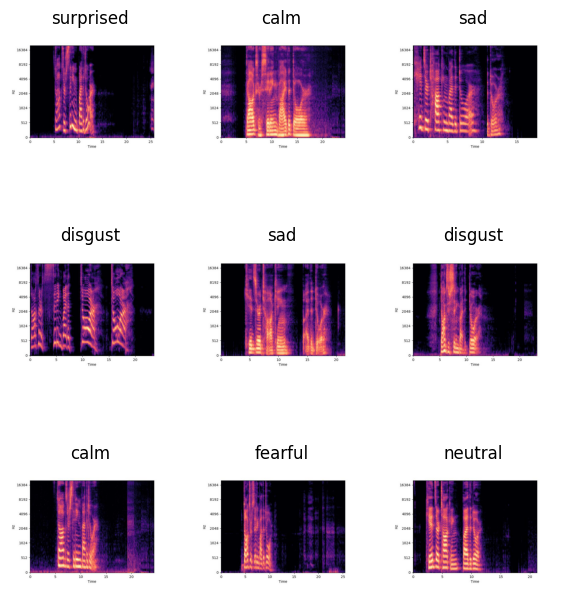

In [ ]:
data.show_batch(figsize=(7,8))

### Training a nueral network
Resnet34 is a CNN -- a deep learning model for processing data that has grid patterns such as images -- that is trained on millions of images of different categories. Therefore, it is a useful general model. We will now use transfer learning to turn resnest34 from a generalist neural network into a specialist neural network that can analyze emotions from spectrograms.

In [ ]:
learn = cnn_learner(data, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

We will have the learner analyze the images 5 times/cycles/epochs. Each time, the learner runs, it gets better at detection.

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.unfreeze()

In [ ]:
# Repeat 3 more times
for i in range(3) :
  learn.fit_one_cycle(5, lr_max=slice(1e-5,1e-4))

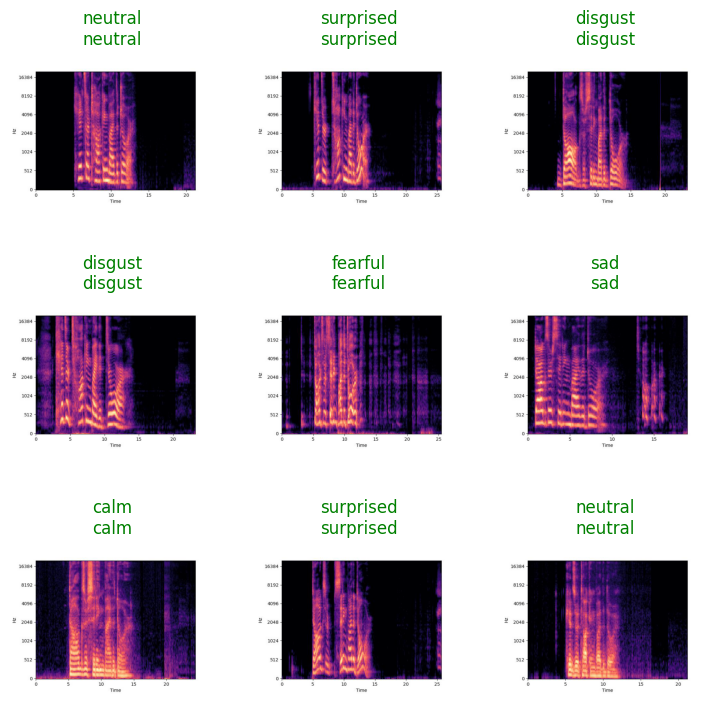

In [ ]:
learn.show_results()

### Validation
We use a confusion matrix because this is a classification problem. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

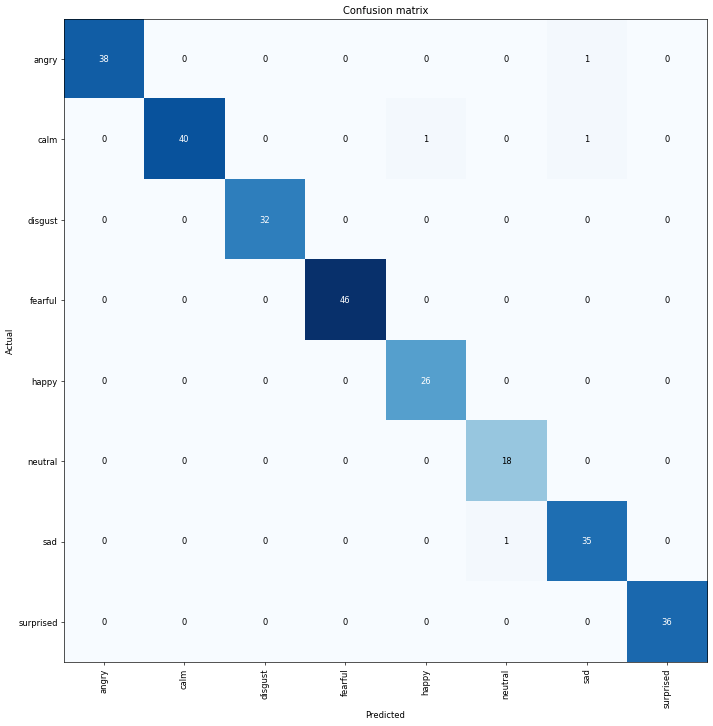

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.freeze()

In [ ]:
learn.export('mod.pkl')

## Testing the Test Data

In [ ]:
# Load the trained CNN model
model = load_learner('/content/drive/MyDrive/QAC_Dataset/train_folder/mod.pkl')

In [ ]:
test_path = Path('/content/drive/MyDrive/QAC_Dataset/test_folder')

In [ ]:
# Loop over each file in the testing data folder
for file_path in get_image_files(test_path, recurse=True):
    # Load and preprocess the image
    img = PILImage.create(file_path)
    
    # Access the predicted labels or probabilities
    predicted_label, _, probs = model.predict(img)
    print(f"File: {file_path}, Predicted Label: {predicted_label}, Probabilities: {probs}")

In [ ]:
# Loop over each file in the testing data folder
for file_path in get_image_files(test_path, recurse=True):
    # Load and preprocess the image
    img = PILImage.create(file_path)
    
    # Access the predicted labels or probabilities
    predicted_label, _, probs = model.predict(img)
    print(f"File: {file_path}, Predicted Label: {predicted_label}, Probabilities: {probs}")

Here is another way we ran the prediction but with **image** ouptuts. We stopped the execution becasue don't need to run the entire code again. Below are just image results to the code cell above.

KeyboardInterrupt: ignored

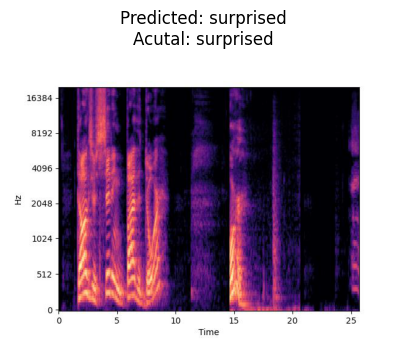

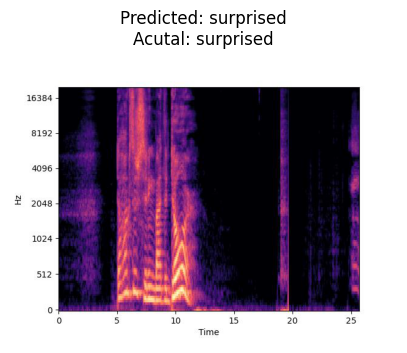

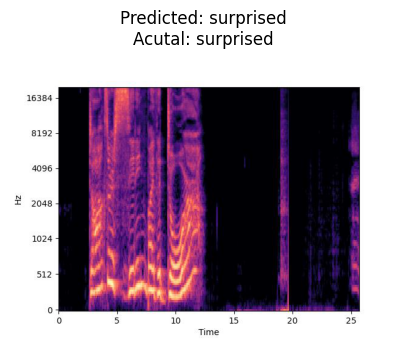

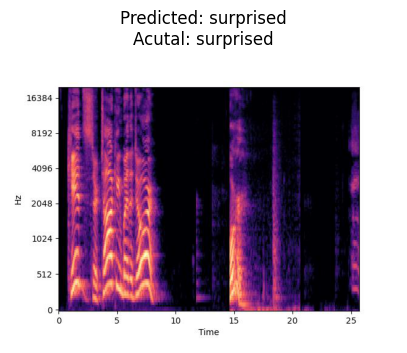

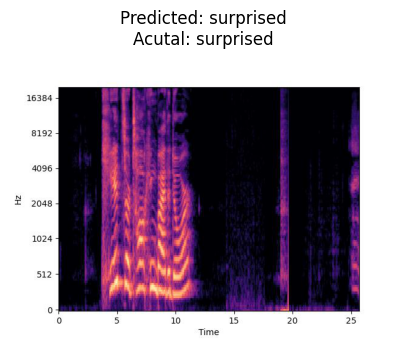

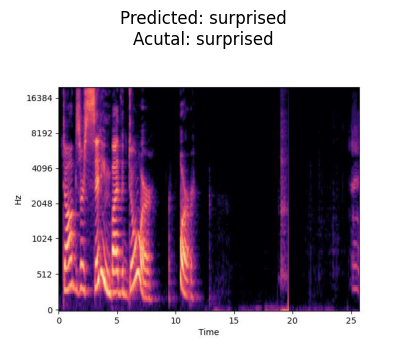

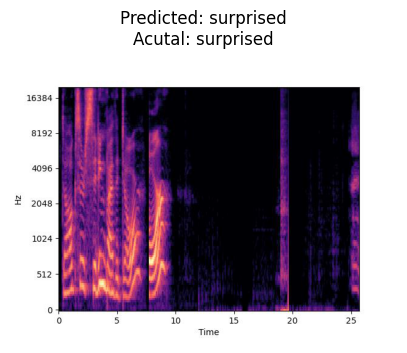

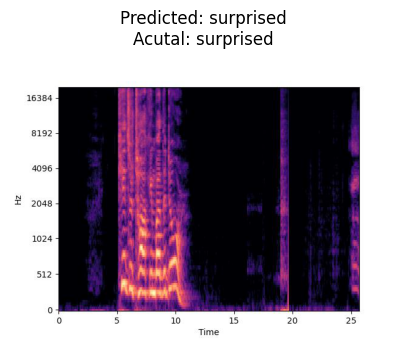

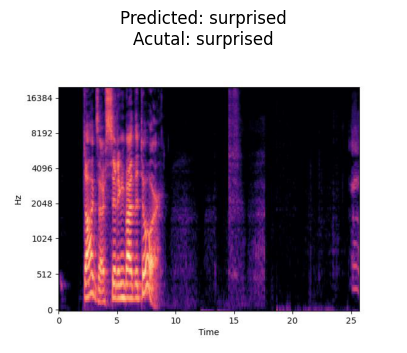

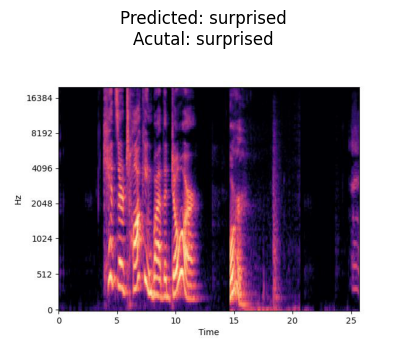

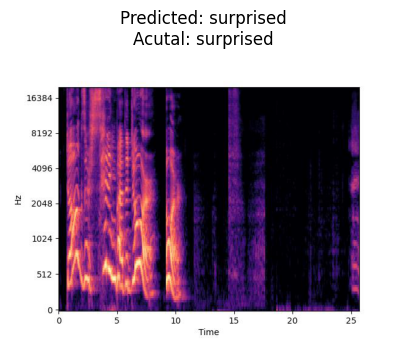

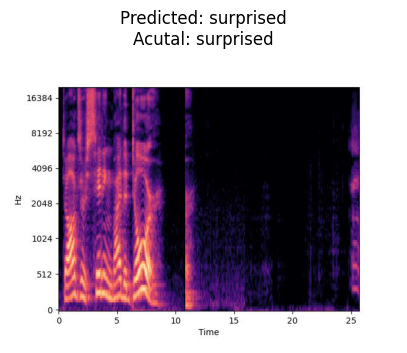

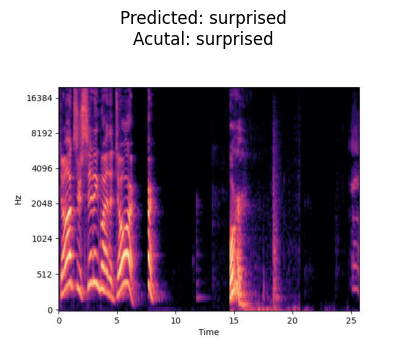

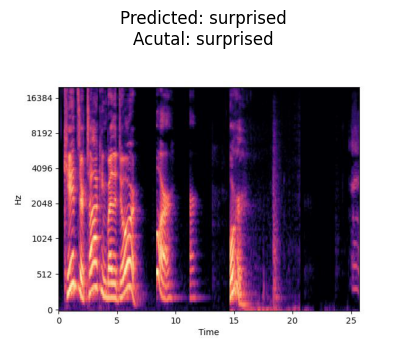

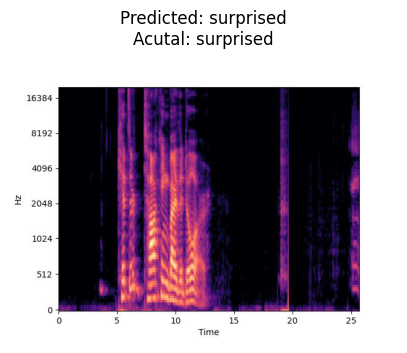

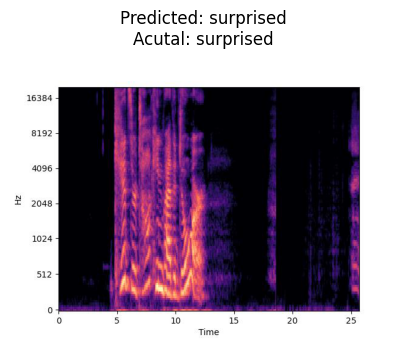

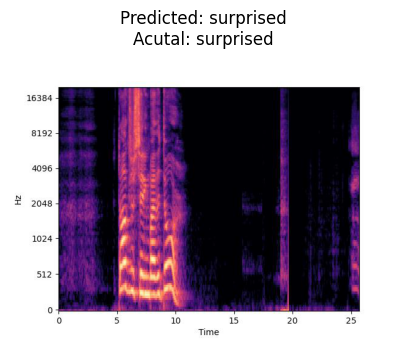

In [ ]:
# Loop over each file in the testing data folder
for file_path in get_image_files(test_path, recurse=True):
    # Load and preprocess the image
    img = PILImage.create(file_path)
    
    # Access the predicted labels or probabilities
    predicted_label, _, probs = model.predict(img)
    path = os.path.normpath(file_path)
    split_path = path.split(os.sep)
    actual_label = split_path[6]
    
    # Show the image and predicted label
    img.show(title = "Predicted: " + predicted_label + "\n" + "Acutal: " + actual_label)

## Live Recording


In [ ]:
import IPython

**NOTE**: This code for recording live below does not work on Google Colab as pyaudio produces some problems. However, the Jupyter Notebook application in Visual Studio Code works. A video is provided such that you can see how it works!


In [ ]:
# Folder to hold live audio
live_audio = Path('c:/Users/jadyn/OneDrive/Desktop/cProgramming/Live_Audio')

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 5  #Adjust the duration as needed
# WAVE_OUTPUT_FILENAME = "output1.wav", outputs file name

audio = pyaudio.PyAudio()

for i in range(1,6):
    num = i
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        frames_per_buffer=CHUNK)

    frames = []
    print('START TALKING')
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print('STOP TALKING')
    stream.stop_stream()
    stream.close()
   

    filename = f'ouput_{num}.wav'
    output_path = os.path.join(live_audio, filename)

    with wave.open(output_path, 'wb') as wavefile:
        #wavefile = wave.open(filename, 'wb')
        wavefile.setnchannels(CHANNELS)
        wavefile.setsampwidth(audio.get_sample_size(FORMAT))
        wavefile.setframerate(RATE)
        wavefile.writeframes(b''.join(frames))

audio.terminate()

ouput_1.wav
/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms/output_1.jpg


What is the predicted emotion:  neutral
ouput_2.wav
/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms/output_2.jpg


What is the predicted emotion:  neutral
ouput_3.wav
/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms/output_3.jpg


What is the predicted emotion:  calm
ouput_4.wav
/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms/output_4.jpg


What is the predicted emotion:  disgust
ouput_5.wav
/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms/output_5.jpg


What is the predicted emotion:  neutral


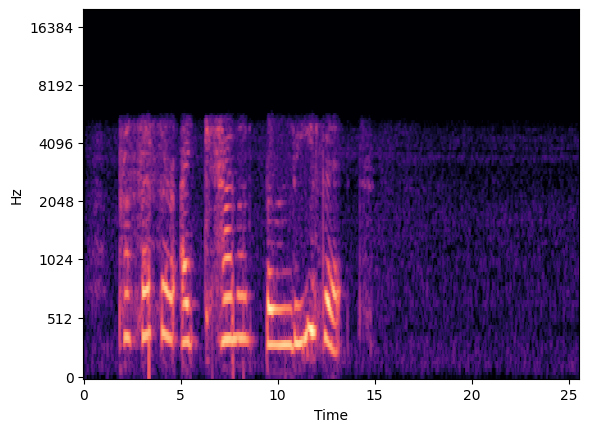

In [ ]:
# Load and preprocess the test audio file

import os
live_audio = Path('/content/drive/MyDrive/QAC_Dataset/Live_Audio')
count = 1

# Iterate over files in the Live Audio folder
for audio_file in os.listdir(live_audio):
    
    if os.path.isfile(os.path.join(live_audio, audio_file)):
        
        # Process each file
        print(audio_file)
        audio_path = os.path.join(live_audio, audio_file)

        y, sr = librosa.load(audio_path)
        yt,_=librosa.effects.trim(y)
        
        # Apply necessary preprocessing to generate the spectrogram representation
        audio_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)

        # Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
        audio_spectogram = librosa.power_to_db(audio_spectogram, ref=np.max)

        # Display the spectrogram with specshow
        librosa.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')

        p = os.path.join('/content/drive/MyDrive/QAC_Dataset/Live Audio Spectrograms', "output_{}.jpg".format(str(count)))
        plt.savefig(p)
        print(p)

        is_what, _, probs = model.predict(p)
        print("The predicted emotion: ", is_what)
        count = count+1

User would be able to check the predicted emotion to the emotion they used when speaking. For these sample recordings, Jadyn used these lines and with these intended emotions:


*   "Why are you here?" (Neutral)
*  "That is so disgusting Samuel." (Disgust)

*   "My dog died yesterday." (Sad)
*   "Oh my god, what are you doing here!?" (Happy)


*   "Professors, I cannot believe it." (Surprised)


**The folder that has these lines, Live_Audio, are uploaded so you can verify whether Jadyn's voice matched the intended emotion or the ones predicted!**

### Predicting Actors' Emotions

Now, lets try this on some audio taken from the Internet! We wanted to test our model under less controlled conditions where audio quality, audio length, audio conditions (i.e., presence of background music or noise), and the type of speech (short sentences) differ and see how our model holds up.











### Example 1:

Video Clip: https://youtu.be/mdypP_qOVI0





In [ ]:
from IPython.display import YouTubeVideo

In [ ]:
!pip install yt-dlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 96.0 MB/s eta 0:00:00


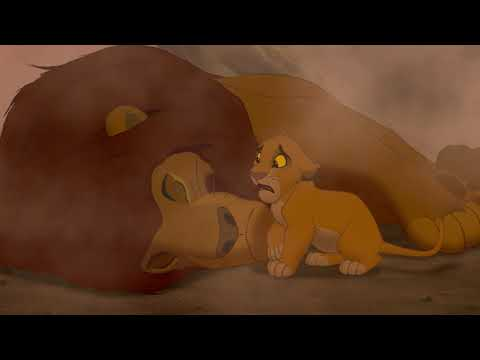

In [ ]:
YouTubeVideo('mdypP_qOVI0')

In [ ]:
# --audio-format FORMAT 
# converts the video to audio of a specific format, using ffmpeg
!yt-dlp -x --audio-format wav mdypP_qOVI0

[youtube] Extracting URL: mdypP_qOVI0
[youtube] mdypP_qOVI0: Downloading webpage
[youtube] mdypP_qOVI0: Downloading android player API JSON
[info] mdypP_qOVI0: Downloading 1 format(s): 251
[dashsegments] Total fragments: 1
[download] Destination: The Lion King 1994 Mufasa Dies [mdypP_qOVI0].webm
[download] 100% of    3.38MiB in 00:00:00 at 17.60MiB/s
[ExtractAudio] Destination: The Lion King 1994 Mufasa Dies [mdypP_qOVI0].wav
Deleting original file The Lion King 1994 Mufasa Dies [mdypP_qOVI0].webm (pass -k to keep)


In [ ]:
# Getting the marvel movie scence that is part of this compilation
!ffmpeg -ss 00:01:45 -i 'The Lion King 1994 Mufasa Dies [mdypP_qOVI0].wav' -to 00:01:56 -c copy 'lion_king.wav' -y

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
audio_file = 'lion_king.wav'

In [ ]:
y, sr = librosa.load(audio_file, mono = True, sr = 16000, duration = 11.0)

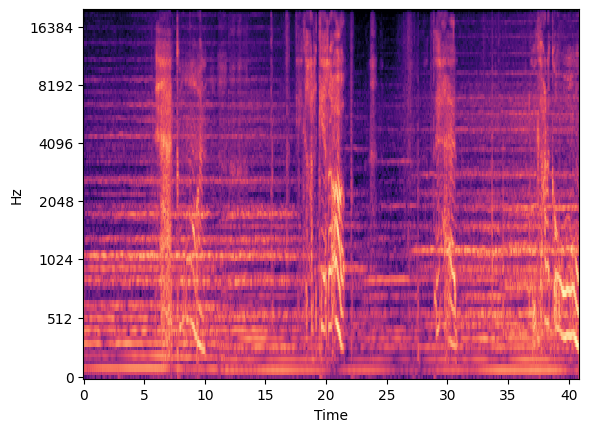

In [ ]:
yt,_=librosa.effects.trim(y)

# Apply necessary preprocessing to generate the spectrogram representation
audio_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)

# Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
audio_spectogram = librosa.power_to_db(audio_spectogram, ref=np.max)

# Display the spectrogram with specshow
librosa.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')
path_save1 = os.path.join('/content/drive/MyDrive/QAC_Dataset/Actor Clips', "lion_king.jpg")
plt.savefig(path_save1)

In [ ]:
# Lets hear the audio clip!
a = IPython.display.Audio(data=y, rate=sr)
a

In [ ]:
is_what, _, probs = model.predict(path_save1)
print("What is the predicted emotion: ", is_what)

What is the predicted emotion:  calm


I think most of us would agree that this scene communicates sadness given the visual scene, the actor's emotions, and the music. However, the predicted emotion is calm, so our model failed in this instance. We will discuss why this is the case.

### Example 2
Full Video: https://youtu.be/gtSeSKLktnc

In [ ]:
#https://youtu.be/gtSeSKLktnc
YouTubeVideo('gtSeSKLktnc')
!yt-dlp -x --audio-format wav gtSeSKLktnc

[youtube] Extracting URL: gtSeSKLktnc
[youtube] gtSeSKLktnc: Downloading webpage
[youtube] gtSeSKLktnc: Downloading android player API JSON
[info] gtSeSKLktnc: Downloading 1 format(s): 251
[download] Sad Movie Scenes That Will Break Your Heart [gtSeSKLktnc].wav has already been downloaded
[ExtractAudio] Destination: Sad Movie Scenes That Will Break Your Heart [gtSeSKLktnc].wav
Deleting original file Sad Movie Scenes That Will Break Your Heart [gtSeSKLktnc].orig.wav (pass -k to keep)


In [ ]:
!ffmpeg -i 'Sad Movie Scenes That Will Break Your Heart [gtSeSKLktnc].wav' 'Revolutionary Road.wav' -y

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

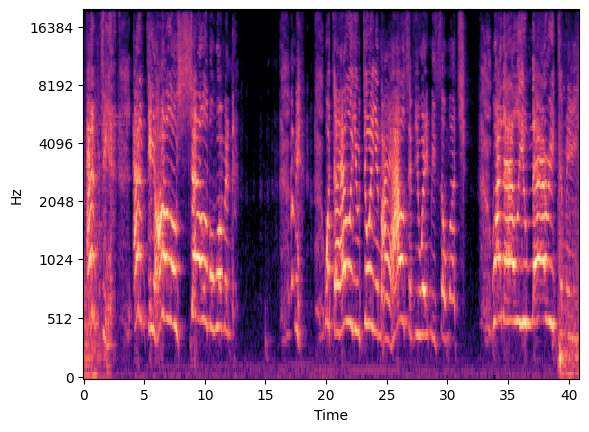

In [ ]:
rev_file = 'Revolutionary Road.wav'

y, sr = librosa.load(rev_file, mono = True, sr = 16000, duration = 11.0)
yt,_=librosa.effects.trim(y)

# Apply necessary preprocessing to generate the spectrogram representation
audio_spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)

# Convert a power spectrogram (amplitude squared) to decibel (dB) units with power_to_db
audio_spectogram = librosa.power_to_db(audio_spectogram, ref=np.max)

# Display the spectrogram with specshow
librosa.display.specshow(audio_spectogram, y_axis='mel', fmax=20000, x_axis='time')
path_save = os.path.join('/content/drive/MyDrive/QAC_Dataset/Actor Clips', "revolutionary_road.jpg")
plt.savefig(path_save)

In [ ]:
is_what, _, probs = model.predict(path_save)
print("What is the predicted emotion: ", is_what)

What is the predicted emotion:  angry


In [ ]:
# Listen to the audio!
a = IPython.display.Audio(data=y, rate=sr)
a

The emotion in this clip is angry, which our model predicted correctly!

## Discussion

A more detailed discussion is present in our paper, but our model is trained on recognizing emotions visually from spectrograms. Our training dataset is characterized by short line readings from actors, conveyed with an intended emotion, without any background noise and using quality equipment.

The second example audio we used more closely matches the characteristics of our training set, so it was not surprising that it correctly predicted the emotions in the audio clip. However, in the audio clip with Simba, audio quality was worse and there was background music, which signficantly distorted the associated spectrogram (we can even see this visually).